# Predict volume area from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.models.ensemble import *
from enveco.metrics import *

Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')

preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
preprocessor.train_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,0
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,0
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,0
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,0
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,0


In [5]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col='v', path=data_path/'AV_las/', 
                                                     min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=True, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True,
                                                     log_y=False)

Adding height based features
Adding point distribution based features
Adding intensity based features
Adding height quantiles
Adding point proportions
Adding canopy densities


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [6]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

Check the distribution of the target variable `g`, in order to get limits for `sigmoid_range`.

In [7]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [8]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [9]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 70 m² as the maximum value for basal area.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [122]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,1000))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 58'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
Linear               64 x 200             11,600     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.002511886414140463)

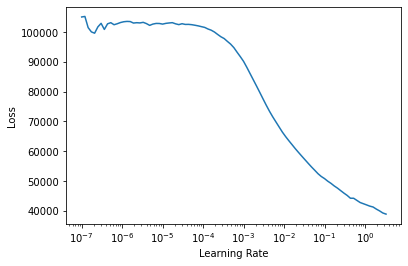

In [123]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,95410.093750,102544.554688,320.225800,212.395508,305.021881,202.311234,307.052185,-10.267640,00:00
1,76925.812500,48783.894531,220.870758,146.496506,201.181625,133.437317,207.513763,-4.360395,00:00
2,52579.570312,10041.494141,100.207253,66.464256,68.081009,45.155952,83.844017,-0.103364,00:00
3,34076.867188,2657.426270,51.550236,34.191620,16.522881,10.959097,37.353462,0.708001,00:00
4,23108.537109,1834.187256,42.827412,28.406048,2.761526,1.831632,29.976576,0.798459,00:00
5,16279.401367,1606.851562,40.085556,26.587465,2.040589,1.353457,28.666290,0.823438,00:00
6,11789.228516,1597.250366,39.965614,26.507912,10.053406,6.668102,27.887674,0.824493,00:00
7,8695.333984,1546.712036,39.328262,26.085176,-2.330109,-1.545487,27.968494,0.830047,00:00
8,6560.725586,1284.006958,35.833042,23.766909,5.382875,3.570288,24.828186,0.858913,00:00
9,5055.888184,1374.727417,37.077316,24.592196,7.689839,5.100424,25.140179,0.848944,00:00


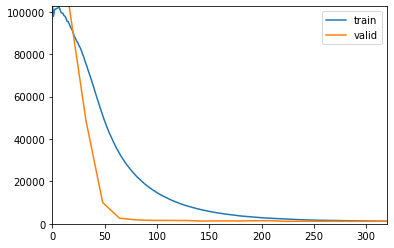

In [124]:
learn.fit_one_cycle(20, max_lr=1e-2, cbs=ShowGraphCallback())

In [125]:
preds, true = learn.get_preds()

In [126]:
preds.shape

torch.Size([225, 1])

See validation results

In [127]:
learn.validate()

(#7) [1226.705810546875,35.02436065673828,23.23053550720215,8.168581008911133,5.417957782745361,24.20854377746582,0.8652090361983558]

`RegressionInterpretation` can be used to plot results.

In [128]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

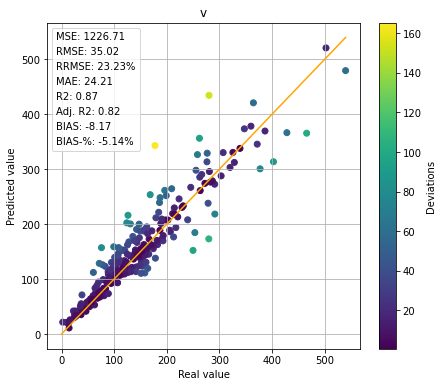

In [129]:
reg_interp.plot_results()
plt.show()

Evaluate test set.

In [130]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [131]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

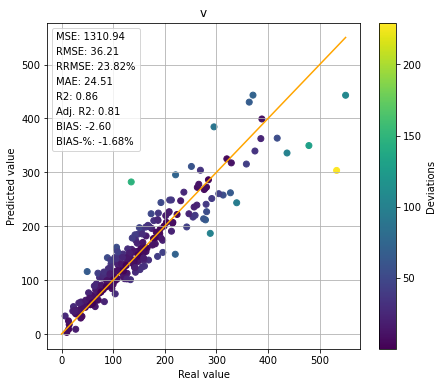

In [132]:
test_interp.plot_results()
plt.show()

# Ensemble of ANNs

Fit several models at once.

In [147]:
ensemble = Ensemble(dls, learn_cls=tabular_learner,
                            y_range=(0,1000), 
                            metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                            n_models=10)

In [148]:
ensemble.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,106654.500000,99838.257812,315.971924,209.574051,305.546600,202.659271,307.198608,-9.970271,00:00
1,70539.679688,20737.630859,144.005661,95.514336,108.998688,72.295341,125.612732,-1.278660,00:00
2,41572.636719,3801.975586,61.660160,40.897209,25.803501,17.114635,44.479805,0.582237,00:00
3,26559.503906,2573.074219,50.725475,33.644581,11.807764,7.831711,35.345818,0.717270,00:00
4,18054.958984,1946.076660,44.114357,29.259640,6.749962,4.477034,31.482615,0.786164,00:00
5,12717.503906,1937.241089,44.014099,29.193142,8.052458,5.340937,31.681200,0.787135,00:00
6,9253.013672,1854.666626,43.065845,28.564194,10.844941,7.193102,30.652800,0.796208,00:00
7,6941.263184,1829.484253,42.772472,28.369608,9.778503,6.485768,30.272009,0.798975,00:00
8,5303.899902,1845.042969,42.953964,28.489988,10.064572,6.675508,29.873758,0.797266,00:00
9,4152.965820,1839.409424,42.888336,28.446461,9.496422,6.298672,29.928082,0.797885,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,167840.093750,131554.109375,362.703888,240.569855,351.542938,233.167160,351.619293,-13.455223,00:00
1,118121.312500,37806.882812,194.439911,128.965759,163.357010,108.349472,174.347565,-3.154237,00:00
2,71230.570312,7137.229004,84.482124,56.034286,47.777843,31.689510,61.368668,0.215758,00:00
3,45230.562500,3657.028809,60.473370,40.110050,13.168231,8.734066,41.449245,0.598164,00:00
4,30503.640625,2199.189453,46.895515,31.104294,-1.338998,-0.888114,32.928169,0.758352,00:00
5,21397.316406,2592.462891,50.916229,33.771103,12.318184,8.170257,34.926102,0.715139,00:00
6,15387.084961,1825.801392,42.729401,28.341043,2.546406,1.688949,30.267776,0.799380,00:00
7,11344.608398,1773.525879,42.113251,27.932369,4.234056,2.808314,30.040148,0.805124,00:00
8,8546.555664,1799.884277,42.425041,28.139172,6.440238,4.271604,30.348488,0.802228,00:00
9,6584.521973,1749.502686,41.827053,27.742544,3.437002,2.279654,29.854105,0.807764,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,148174.453125,121613.726562,348.731598,231.302505,337.953827,224.153946,338.755219,-12.362967,00:00
1,101506.632812,32883.750000,181.338760,120.276192,139.774780,92.708138,156.889908,-2.613280,00:00
2,61152.062500,5479.430176,74.023178,49.097202,36.912289,24.482737,54.092030,0.397918,00:00
3,38955.847656,2980.243652,54.591610,36.208866,6.615279,4.387702,37.924625,0.672530,00:00
4,26285.806641,2572.608887,50.720890,33.641541,6.310972,4.185865,34.467690,0.717321,00:00
5,18428.033203,2290.809570,47.862404,31.745598,6.173816,4.094894,32.656761,0.748285,00:00
6,13246.808594,2025.415527,45.004616,29.850119,4.497419,2.982994,31.384146,0.777446,00:00
7,9768.153320,2024.394043,44.993267,29.842590,8.650012,5.737276,31.550594,0.777559,00:00
8,7361.348633,2006.207764,44.790710,29.708242,8.582853,5.692731,31.282778,0.779557,00:00
9,5723.072754,1990.396973,44.613865,29.590946,6.444503,4.274432,31.098574,0.781294,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,130765.625000,110177.468750,331.929901,220.158463,321.940033,213.532501,321.940094,-11.106348,00:00
1,91971.609375,30338.445312,174.179352,115.527580,140.320374,93.070007,155.588867,-2.333601,00:00
2,55668.742188,4384.246094,66.213646,43.917389,32.107616,21.295954,51.200638,0.518257,00:00
3,35527.550781,2217.216309,47.087326,31.231514,-2.264485,-1.501960,33.173374,0.756371,00:00
4,24043.580078,1857.317261,43.096603,28.584597,-2.482696,-1.646693,30.040588,0.795917,00:00
5,16888.769531,1746.087646,41.786213,27.715456,4.231572,2.806666,29.454838,0.808139,00:00
6,12196.525391,1726.639404,41.552853,27.560675,7.739930,5.133648,29.406078,0.810276,00:00
7,9033.327148,1560.846069,39.507542,26.204086,2.347066,1.556734,27.559813,0.828494,00:00
8,6841.645508,1577.094727,39.712654,26.340130,2.959912,1.963215,27.791578,0.826708,00:00
9,5341.859863,1579.399536,39.741665,26.359373,2.915407,1.933696,27.723145,0.826455,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,128511.828125,104965.570312,323.983887,214.888123,307.835144,204.177185,310.661865,-10.533661,00:00
1,84226.125000,20955.099609,144.758759,96.013847,108.832901,72.185371,127.295685,-1.302555,00:00
2,49386.265625,3601.433350,60.011940,39.803997,21.243002,14.089803,41.702465,0.604273,00:00
3,31639.189453,2468.994385,49.688972,32.957104,-9.251769,-6.136402,34.688370,0.728706,00:00
4,21589.671875,2772.314697,52.652771,34.922894,-12.376845,-8.209165,34.661755,0.695377,00:00
5,15340.807617,1970.752808,44.393162,29.444561,4.089300,2.712302,31.045321,0.783453,00:00
6,11121.650391,1863.716431,43.170784,28.633797,4.473846,2.967359,30.264631,0.795214,00:00
7,8293.439453,1820.238770,42.664253,28.297832,1.573608,1.043723,29.881603,0.799991,00:00
8,6330.225098,1881.075684,43.371368,28.766838,4.578059,3.036480,30.305323,0.793307,00:00
9,4918.402344,1872.856079,43.276508,28.703922,4.153089,2.754611,30.111849,0.794210,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,89209.562500,80828.000000,284.302673,188.568848,271.984161,180.398376,274.182281,-7.881416,00:00
1,57953.082031,16059.208984,126.724930,84.052589,91.101807,60.424908,109.846848,-0.764593,00:00
2,34481.812500,3744.321045,61.190861,40.585934,27.572445,18.287918,43.389423,0.588572,00:00
3,22171.144531,2524.985596,50.249233,33.328705,11.034989,7.319154,34.533619,0.722553,00:00
4,15112.294922,1689.117310,41.098869,27.259562,-0.170112,-0.112830,28.765373,0.814399,00:00
5,10751.726562,1658.433228,40.723866,27.010834,8.833310,5.858851,28.285614,0.817771,00:00
6,7958.140625,1506.448853,38.812996,25.743416,4.815385,3.193890,26.626831,0.834471,00:00
7,6055.200195,1514.626709,38.918205,25.813198,4.066364,2.697089,26.739658,0.833572,00:00
8,4701.052246,1526.639893,39.072239,25.915363,6.850863,4.543958,26.985777,0.832252,00:00
9,3715.382812,1502.420166,38.761066,25.708973,5.702690,3.782412,26.709057,0.834913,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,103913.898438,91321.750000,302.194885,200.436188,290.572479,192.727417,291.880096,-9.034474,00:00
1,69020.718750,18543.439453,136.174301,90.320053,104.526741,69.329231,119.727989,-1.037561,00:00
2,40943.023438,2686.549561,51.831936,34.378464,14.258347,9.457105,37.014427,0.704801,00:00
3,26331.226562,1810.888062,42.554531,28.225056,-2.573019,-1.706601,29.578520,0.801019,00:00
4,17914.105469,2679.549561,51.764362,34.333645,14.382727,9.539602,33.552124,0.705570,00:00
5,12616.720703,1566.465088,39.578590,26.251211,2.484176,1.647674,27.777267,0.827876,00:00
6,9196.290039,1493.843750,38.650276,25.635490,2.551851,1.692561,26.810261,0.835856,00:00
7,6897.274414,1468.621826,38.322601,25.418154,4.436641,2.942682,26.568270,0.838627,00:00
8,5275.190430,1439.054443,37.934868,25.160984,3.256378,2.159851,26.315384,0.841876,00:00
9,4139.156738,1520.350464,38.991673,25.861927,6.606601,4.381947,27.212633,0.832943,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,105560.500000,97113.554688,311.630463,206.694504,299.673065,198.763535,301.023956,-9.670879,00:00
1,70642.750000,20666.025391,143.756821,95.349297,109.756790,72.798157,127.993141,-1.270792,00:00
2,42016.765625,3263.723633,57.129009,37.891842,20.099453,13.331323,38.121494,0.641381,00:00
3,26868.357422,1856.644531,43.088802,28.579422,-5.241014,-3.476197,29.670456,0.795991,00:00
4,18261.148438,1709.707886,41.348614,27.425209,-1.137240,-0.754295,28.104164,0.812137,00:00
5,12912.333984,1591.811646,39.897514,26.462742,5.280744,3.502548,27.515663,0.825091,00:00
6,9453.877930,1741.928223,41.736412,27.682423,6.983736,4.632088,27.586786,0.808596,00:00
7,7034.530762,1512.730225,38.893829,25.797029,1.952792,1.295224,26.487524,0.833781,00:00
8,5381.648926,1507.750977,38.829769,25.754541,0.751415,0.498389,26.499626,0.834328,00:00
9,4234.170898,1482.456909,38.502686,25.537598,1.399356,0.928148,26.315228,0.837107,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,164530.656250,129073.718750,359.268280,238.291138,344.511566,228.503479,345.803223,-13.182675,00:00
1,117183.304688,37167.546875,192.788849,127.870667,155.791336,103.331398,171.042877,-3.083986,00:00
2,70687.117188,5405.525879,73.522285,48.764973,36.715034,24.351906,53.185677,0.406038,00:00
3,44956.781250,2441.253174,49.409042,32.771435,-3.036951,-2.014313,34.011539,0.731754,00:00
4,30233.914062,2103.930908,45.868629,30.423191,-0.182798,-0.121244,30.971077,0.768819,00:00
5,21140.267578,1938.840820,44.032269,29.205191,2.995278,1.986672,29.751766,0.786959,00:00
6,15287.083984,1710.673584,41.360287,27.432951,0.763426,0.506356,28.009880,0.812030,00:00
7,11220.070312,1686.004272,41.060986,27.234436,5.199923,3.448942,28.064939,0.814741,00:00
8,8409.224609,1672.750732,40.899277,27.127180,3.803717,2.522884,27.913605,0.816197,00:00
9,6477.733398,1690.020264,41.109856,27.266848,2.631561,1.745430,27.942358,0.814300,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,109086.921875,95096.078125,308.376495,204.536255,297.619934,197.401764,297.825897,-9.449199,00:00
1,70942.843750,19030.042969,137.949432,91.497437,97.001175,64.337769,117.931648,-1.091029,00:00
2,41860.718750,3917.581055,62.590584,41.514328,25.866690,17.156546,43.556889,0.569534,00:00
3,26766.400391,1985.187256,44.555443,29.552197,-1.157476,-0.767717,31.525862,0.781867,00:00
4,18234.697266,1713.773438,41.397747,27.457798,2.065459,1.369953,29.211563,0.811690,00:00
5,12906.792969,1597.946655,39.974327,26.513689,6.012105,3.987636,28.178312,0.824417,00:00
6,9430.055664,1527.901978,39.088387,25.926075,4.284705,2.841908,27.362560,0.832113,00:00
7,7108.255371,1559.631348,39.492168,26.193890,5.490319,3.641552,27.397062,0.828627,00:00
8,5452.115234,1474.746948,38.402435,25.471104,0.975965,0.647327,26.979691,0.837954,00:00
9,4327.379883,1463.492798,38.255623,25.373728,2.305753,1.529332,26.828720,0.839191,00:00


In [152]:
res = ensemble.validate()

See ensemble validation results.

In [153]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,37.664650,24.981754,4.509238,2.990833,26.224834,0.844121
1,0,42.888336,28.446461,9.496422,6.298672,29.928083,0.797885
2,1,41.827053,27.742544,3.437002,2.279654,29.854103,0.807764
3,2,44.613865,29.590946,6.444503,4.274432,31.098576,0.781294
4,3,39.741665,26.359373,2.915407,1.933696,27.723145,0.826455
5,4,43.276508,28.703922,4.153089,2.754611,30.111851,0.794210
6,5,38.761066,25.708973,5.702690,3.782412,26.709057,0.834913
7,6,38.991673,25.861927,6.606601,4.381947,27.212633,0.832943
8,7,38.502686,25.537598,1.399356,0.928148,26.315228,0.837107
9,8,41.109856,27.266848,2.631561,1.745430,27.942358,0.814300


In [154]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

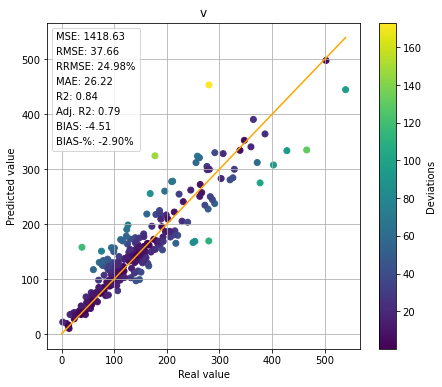

In [155]:
ens_int.plot_results()
plt.show()

Run test set predictions.

In [156]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,37.549072,24.701120,0.280901,0.184787,26.344427,0.850174
1,0,40.461376,26.616938,1.631808,1.073462,27.427498,0.826032
2,1,41.661247,27.406254,0.249005,0.163804,29.692301,0.815561
3,2,40.568108,26.687149,0.654419,0.430500,29.995632,0.825113
4,3,41.159740,27.076345,-1.524007,-1.002546,29.200705,0.819974
5,4,39.734867,26.139015,1.511680,0.994437,27.819839,0.832223
6,5,39.140400,25.747952,1.237117,0.813820,28.167511,0.837206
7,6,38.635872,25.416056,2.668761,1.755607,28.197281,0.841375
8,7,41.322311,27.183290,-1.716707,-1.129311,27.824512,0.818550
9,8,42.751995,28.123791,-0.647703,-0.426082,31.168877,0.805777


In [161]:
run_test_res = test_res[test_res.model_identifier != 'ensemble']

In [157]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

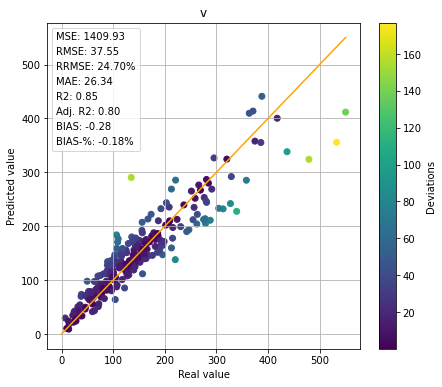

In [158]:
test_ens_interp.plot_results()
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [30]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [31]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [32]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [33]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

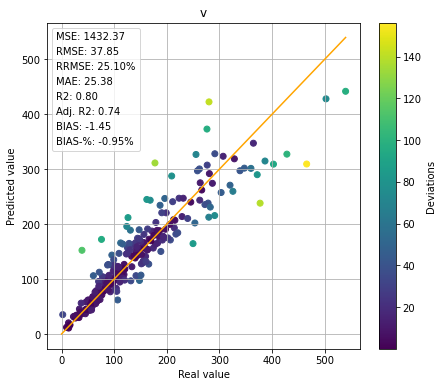

In [34]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

Test results

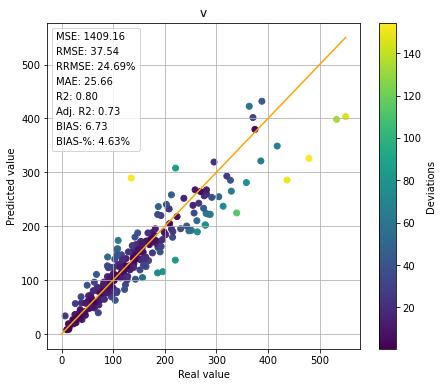

In [35]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()

# Comparison: Support Vector Regressor

In [36]:
from sklearn.svm import SVR

In [136]:
svr = SVR(kernel='rbf', C=128)
svr.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

SVR(C=128)

In [134]:
svr_preds = svr.predict(trainval_tb.valid.xs)

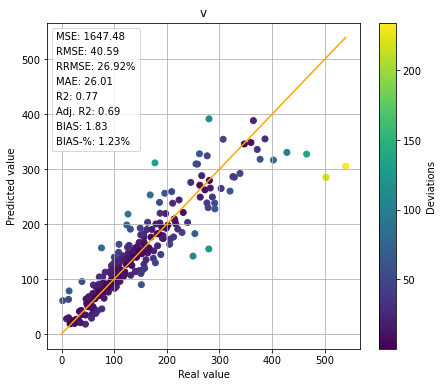

In [135]:
plot_sklearn_regression(svr, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()